**Fast and accurate calculations for first-passage times in Wiener diffusion models**  
Daniel Navarro, Ian Fuss (2009)

**PDF**:

$w = z/a$

\begin{align*}
f(t|v,a,w) & =\frac{\pi}{a^2}\exp\left(-vaw-\frac{v^2t}{2}\right) \times\sum_{k=1}^\infty k\exp\left(-\frac{k^2\pi^2t}{2a^2}\right)\sin(k\pi w)
\end{align*}

In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pyddm
from autograd import hessian, jacobian
from scipy.optimize import minimize


def pdf(ts, v, a, z, err=0.001, boundary="lower"):
    """a>0, z∈[0,a], t>0, boundary={'lower', 'upper'}"""

    if boundary == "lower":
        v = v
        w = z / a  # relative starting point (0 to 1)
    elif boundary == "upper":
        v = -v
        w = 1 - (z / a)

    tt = ts / (a**2)  # normalize time

    # kl: number of terms for large t
    kl = np.where(
        np.pi * tt * err < 1,
        np.sqrt(-2 * np.log(np.pi * tt * err) / (np.pi**2 * tt)),
        1 / (np.pi * np.sqrt(tt)),
    )
    kl = np.maximum(kl, 1 / (np.pi * np.sqrt(tt)))

    # ks: number of terms for small t
    ks = np.where(
        2 * np.sqrt(2 * np.pi * tt) * err < 1,
        2 + np.sqrt(-2 * tt * np.log(2 * np.sqrt(2 * np.pi * tt) * err)),
        2,
    )
    ks = np.maximum(ks, np.sqrt(tt) + 1)

    # f(tt|0,1,w)
    mask_small_t = ks < kl

    # small t approximation
    K_small = np.ceil(ks).astype(int)
    Ks_small = np.arange(-((K_small.max() - 1) // 2), ((K_small.max() - 1) // 2) + 1)
    exponent_small = -((w + 2 * Ks_small[:, None]) ** 2) / (2 * tt)
    p_small_t = np.sum((w + 2 * Ks_small[:, None]) * np.exp(exponent_small), axis=0) / np.sqrt(
        2 * np.pi * tt**3
    )

    # large t approximation
    K_large = np.ceil(kl).astype(int)
    Ks_large = np.arange(1, K_large.max() + 1)
    exponent_large = -(Ks_large[:, None] ** 2) * (np.pi**2) * tt / 2
    p_large_t = np.pi * np.sum(
        Ks_large[:, None] * np.exp(exponent_large) * np.sin(Ks_large[:, None] * np.pi * w), axis=0
    )

    # combine small t and large t approximations
    p = np.where(mask_small_t, p_small_t, p_large_t)

    # f(t|v,a,w)
    p *= np.exp(-v * a * w - (v**2) * ts / 2) / (a**2)

    return p

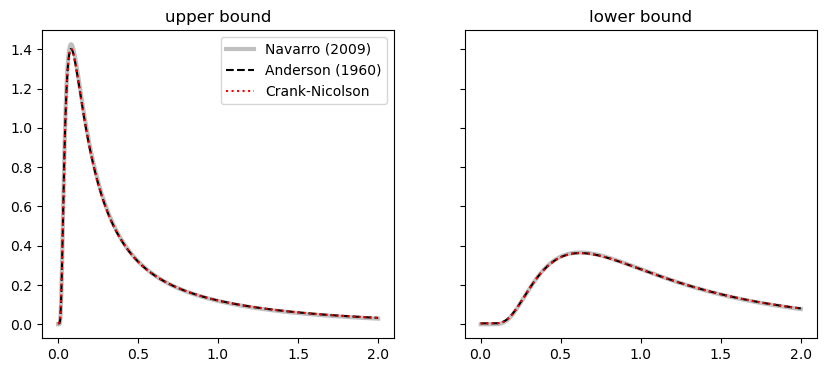

In [2]:
pyddm_params = {"v": -0.5, "a": 1, "z": 0.5}
ddm = pyddm.gddm(
    drift=pyddm_params["v"],
    bound=pyddm_params["a"],
    starting_position=pyddm_params["z"],
    nondecision=0,
    noise=1.0,
)

# anderson: ddm -> pdf
and_sol = ddm.solve_analytical()

# crank-nicolson: ddm -> pdf
cn_sol = ddm.solve_numerical_cn()

# navarro: ddm -> pdf
nav_params = {
    "v": pyddm_params["v"],
    "a": 2 * pyddm_params["a"],
    "z": pyddm_params["a"] * (pyddm_params["z"] + 1),
}

tmin, tmax, num = 0.001, 2, 500
ts = np.linspace(tmin, tmax, num)

fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)

pdf_upper = pdf(ts, **nav_params, boundary="upper")
axs[0].set_title("upper bound")
axs[0].plot(ts, pdf_upper, lw=3, c="k", alpha=0.25, label="Navarro (2009)")
axs[0].plot(
    and_sol.t_domain, and_sol.pdf(choice="correct"), ls="--", c="k", label="Anderson (1960)"
)
axs[0].plot(and_sol.t_domain, cn_sol.pdf(choice="correct"), ls=":", c="r", label="Crank-Nicolson")
axs[0].legend()


pdf_lower = pdf(ts, **nav_params, boundary="lower")
axs[1].set_title("lower bound")
axs[1].plot(ts, pdf_lower, lw=3, c="k", alpha=0.25)
axs[1].plot(and_sol.t_domain, and_sol.pdf(choice="error"), ls="--", c="k")
axs[1].plot(and_sol.t_domain, cn_sol.pdf(choice="error"), ls=":", c="r")

**discretization and sampling**

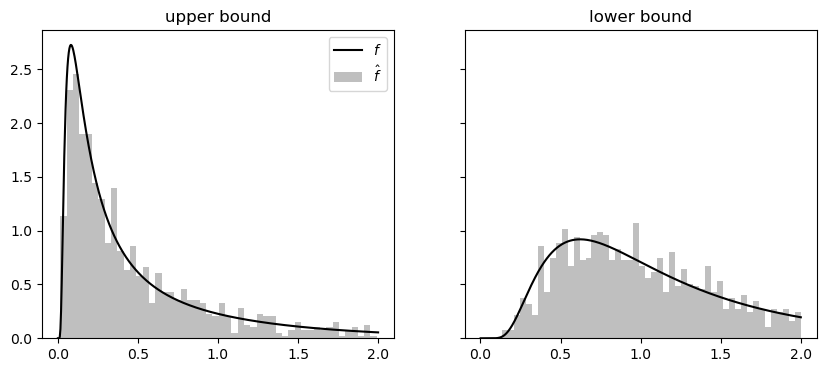

In [3]:
def sample_from_pdf(ts, v, a, z, boundary="lower", n_samples=10, seed=0):
    rng = np.random.default_rng(seed=seed)
    pdf_ = pdf(ts, v, a, z, boundary=boundary)
    probs_ = pdf_ / np.sum(pdf_)  # probabilities sum to 1
    return rng.choice(ts, size=n_samples, p=probs_)


n_samples = 1000
samples_upper = sample_from_pdf(ts, **nav_params, boundary="upper", n_samples=n_samples)
samples_lower = sample_from_pdf(ts, **nav_params, boundary="lower", n_samples=n_samples)

fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)
axs[0].set_title("upper bound")
axs[0].plot(ts, pdf_upper / (np.sum(pdf_upper) * (tmax - tmin) / num), c="k", label=r"$f$")
axs[0].hist(samples_upper, bins=50, density=True, color="k", alpha=0.25, label=r"$\hat f$")

axs[1].set_title("lower bound")
axs[1].plot(ts, pdf_lower / (np.sum(pdf_lower) * (tmax - tmin) / num), c="k")
axs[1].hist(samples_lower, bins=50, density=True, color="k", alpha=0.25)
axs[0].legend()

**maximum likelihood estimation**

In [4]:
def loglikelihood(params, samples_upper, samples_lower, epsilon=1e-10):
    likelihoods_upper = np.log(pdf(samples_upper, *params, boundary="upper") + epsilon)
    likelihoods_lower = np.log(pdf(samples_lower, *params, boundary="lower") + epsilon)
    return np.concatenate([likelihoods_upper, likelihoods_lower])  # !! check !!


def lossloglikelihood(params, samples_upper, samples_lower):
    loglikelihood_ = loglikelihood(params, samples_upper, samples_lower)
    return -np.sum(loglikelihood_)


# define autograd derivatives
ll_jacobian = jacobian(loglikelihood)
lll_jacobian = jacobian(lossloglikelihood)
lll_hessian = hessian(lossloglikelihood)

fit = minimize(
    fun=lossloglikelihood,
    x0=[0.1, 1.0, 0.1],
    args=(samples_upper, samples_lower),
    method="Newton-CG",
    jac=lll_jacobian,
    hess=lll_hessian,
)
print(
    "   true\testimate",
    f"v: {nav_params['v']}\t{fit.x[0]:.2f}",
    f"a: {nav_params['a']}\t{fit.x[1]:.2f}",
    f"z: {nav_params['z']}\t{fit.x[2]:.2f}",
    sep="\n",
)

   true	estimate
v: -0.5	-0.65
a: 2	1.91
z: 1.5	1.41


**standard error estimation**

In [5]:
def newey_west(x, n_lags=None):
    n = len(x)
    if n_lags is None:
        n_lags = int(np.floor(4 * (n / 100.0) ** (2.0 / 9.0)))
    x = x[:, np.newaxis] if x.ndim == 1 else x
    weights = 1 - np.arange(n_lags + 1) / (n_lags + 1)  # bartlett
    S = x.T @ x
    for lag in range(1, n_lags + 1):
        s = x[lag:].T @ x[:-lag]
        S += weights[lag] * (s + s.T)  # symmetric over +/- lags
    return S


n = 2 * n_samples  # upper and lower bounds

# sample hessian estimator
hessian_ = (1 / n) * lll_hessian(fit.x, samples_upper, samples_lower)
hessian_cov_ = np.linalg.inv(hessian_)
print("sample hessian estimator:\t", np.sqrt((1 / n) * np.diag(hessian_cov_)))

# outer product estimator
jacobian_ = ll_jacobian(fit.x, samples_upper, samples_lower)
fisher_ = (1 / n) * (jacobian_.T @ jacobian_)  # outer products
fisher_cov_ = np.linalg.inv(fisher_)
print("outer product estimator:\t", np.sqrt((1 / n) * np.diag(fisher_cov_)))

# misspecification robust estimator
robust_var_ = hessian_cov_ @ fisher_ @ hessian_cov_
print("misspecification robust estimator:\t", np.sqrt((1 / n) * np.diag(robust_var_)))

# hac robust (newey-west) estimator
nw_ = (1 / n) * newey_west(jacobian_)
nw_cov_ = hessian_cov_ @ nw_ @ hessian_cov_
print("hac robust (newey-west) estimator:\t", np.sqrt((1 / n) * np.diag(nw_cov_)))

sample hessian estimator:	 [0.03293413 0.02049033 0.02257929]
outer product estimator:	 [0.03030133 0.0227341  0.02377251]
misspecification robust estimator:	 [0.03602791 0.01919684 0.02231702]
hac robust (newey-west) estimator:	 [0.0864695  0.0300658  0.03037308]
